# Imports

In [1]:
import spacy
import os,random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pickle import dump,load
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM,Bidirectional,Dense,Embedding,GRU,Input,Conv2D,MaxPool2D,Dropout,Flatten

In [3]:
nlp = spacy.load('en_core_web_md')

In [4]:
def readData(fileName):
    with open(fileName,encoding='utf8') as file:
        return file.read()

In [5]:
def seperatePunc(docText):
    symbols = set(['\n\n','\n\n\n','!','"','-','#','$','%','&','(',')','--', \
                   '.','*','+',',','-','/','<','=',']' \
                   ,'>','?','@','[','^','_','`','{','}',',','¬','\t','\n','—',';',':'])
    return [token.text for token in nlp(docText) if token.text not in symbols]

In [6]:
doc = readData('paragraphs.txt')

In [7]:
doc = seperatePunc(doc)

In [8]:
startSeq,endSeq = '<START>', '<END>'

In [9]:
def createSentences(docText):
    trainLength = 3
    textSequences = []
    for i in range(trainLength,len(docText),3):
        seq = [startSeq]
        for word in docText[i-trainLength:i]:
            seq += [' ',word]
        seq += [' ',endSeq]
        textSequences.append(seq)
    return textSequences

In [10]:
shortSentences = createSentences(doc)[:3000]

In [11]:
# len(shortSentences),len(xFeatures2['encoderInput'])
shortSentences

[['<START>', ' ', 'He', ' ', 'stared', ' ', 'out', ' ', '<END>'],
 ['<START>', ' ', 'the', ' ', 'window', ' ', 'at', ' ', '<END>'],
 ['<START>', ' ', 'the', ' ', 'snowy', ' ', 'field', ' ', '<END>'],
 ['<START>', ' ', 'He', ' ', "'d", ' ', 'been', ' ', '<END>'],
 ['<START>', ' ', 'stuck', ' ', 'in', ' ', 'the', ' ', '<END>'],
 ['<START>', ' ', 'house', ' ', 'for', ' ', 'close', ' ', '<END>'],
 ['<START>', ' ', 'to', ' ', 'a', ' ', 'month', ' ', '<END>'],
 ['<START>', ' ', 'and', ' ', 'his', ' ', 'only', ' ', '<END>'],
 ['<START>', ' ', 'view', ' ', 'of', ' ', 'the', ' ', '<END>'],
 ['<START>', ' ', 'outside', ' ', 'world', ' ', 'was', ' ', '<END>'],
 ['<START>', ' ', 'through', ' ', 'the', ' ', 'window', ' ', '<END>'],
 ['<START>', ' ', 'There', ' ', 'was', ' ', "n't", ' ', '<END>'],
 ['<START>', ' ', 'much', ' ', 'to', ' ', 'see', ' ', '<END>'],
 ['<START>', ' ', 'It', ' ', 'was', ' ', 'mostly', ' ', '<END>'],
 ['<START>', ' ', 'just', ' ', 'the', ' ', 'field', ' ', '<END>'],
 ['<STAR

In [12]:
df = pd.DataFrame()

In [13]:
%%time
df['Labels'] = [''.join(word) for word in shortSentences]

CPU times: total: 15.6 ms
Wall time: 28.2 ms


In [14]:
%%time
df['imagesId'] = ['dataImages/img-{}.jpg'.format(index) for index,word in enumerate(shortSentences)]

CPU times: total: 0 ns
Wall time: 5.05 ms


In [15]:
df['raw'] = [''.join(word[2:-2]) for word in shortSentences]
df

,Labels,imagesId,raw
0,<START> He stared out <END>,dataImages/img-0.jpg,He stared out
1,<START> the window at <END>,dataImages/img-1.jpg,the window at
2,<START> the snowy field <END>,dataImages/img-2.jpg,the snowy field
3,<START> He 'd been <END>,dataImages/img-3.jpg,He 'd been
4,<START> stuck in the <END>,dataImages/img-4.jpg,stuck in the
...,...,...,...
2995,<START> n't think that <END>,dataImages/img-2995.jpg,n't think that
2996,<START> anyone else besides <END>,dataImages/img-2996.jpg,anyone else besides
2997,<START> her had even <END>,dataImages/img-2997.jpg,her had even
2998,<START> noticed it It <END>,dataImages/img-2998.jpg,noticed it It


In [16]:
df.to_csv('caption_dataset.csv')

# Imports

In [17]:
plt.imread('dataImages/img-0.jpg').shape

(500, 850, 3)

# Cleaning the image dataset

In [18]:

def processImage(imagePath,imageSize):
    """
    Takes an image file path and turns the image into a Tensor
    """
    #Read in an image file
    image = tf.io.read_file(imagePath)
    #Turn the jpg image into numerical Tensors with 3 colour chanels(RGB)
    image = tf.image.decode_jpeg(image,channels=3)
    # Convert the color channel values from 0 255 to 0 1
    # Normalization
    image = tf.image.convert_image_dtype(image,tf.float32)
    # Resize the image (224,224)
    image = tf.image.resize(image,size=[imageSize[0],imageSize[1]])
    
    return image

In [19]:
LabelText = df['imagesId']
len(LabelText)

3000

<START> from Las Vegas <END>


(102, <matplotlib.image.AxesImage at 0x1494cef3520>, None)

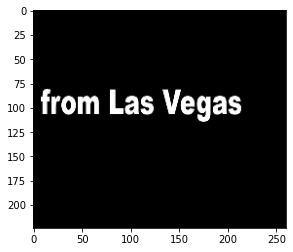

In [20]:
idx = random.randint(0,len(LabelText))
image = processImage(LabelText[idx],(224, 260))
idx,plt.imshow(image),print(df.Labels[idx])

('<START> from Las Vegas <END>', <matplotlib.image.AxesImage at 0x1494d5bd0a0>)

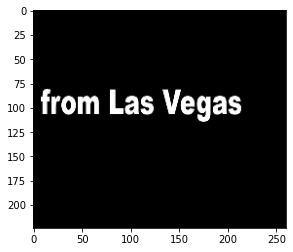

In [21]:
df['Labels'][idx],plt.imshow(image)

In [22]:
def preprocessImages(paths:list[str] = LabelText,processImage = processImage,imageShape=(224,260)):
    for imagePath in paths:
        yield processImage(imagePath,imageShape)

In [23]:
%%time
# processImage is the function above , 
# labelText a list of paths
#xFeatures = preprocessImages(LabelText,processImage)
xFeatures = tf.data.Dataset.from_generator(preprocessImages,output_types='float32')

CPU times: total: 93.8 ms
Wall time: 123 ms


# Processing the Text Input for the Decoder Layer

In [24]:
def convertToChar(shortSents,forDecoderInput):
    # for decoder input checks what the text data is used for ie
    #(input decoder layer or output decoder layer)
    startEnd = {startSeq,endSeq}
    output = []
    for sent in shortSents:
        if not forDecoderInput:
            sent = sent[2:]
        result = []
        for word in sent: 
            if word not in startEnd:
                for char in word:
                    result.append(char)
            else:
                result.append(word)
                continue
        output.append(result) 
    return output
                

In [25]:
shortSentences[:4]

[['<START>', ' ', 'He', ' ', 'stared', ' ', 'out', ' ', '<END>'],
 ['<START>', ' ', 'the', ' ', 'window', ' ', 'at', ' ', '<END>'],
 ['<START>', ' ', 'the', ' ', 'snowy', ' ', 'field', ' ', '<END>'],
 ['<START>', ' ', 'He', ' ', "'d", ' ', 'been', ' ', '<END>']]

In [26]:
tokenizer = Tokenizer(lower=False)

In [27]:
sentenceSequence = convertToChar(shortSentences,forDecoderInput=True)
# sentenceSequence = shortSentences

In [28]:
[print(i) for i in sentenceSequence[:5]]

['<START>', ' ', 'H', 'e', ' ', 's', 't', 'a', 'r', 'e', 'd', ' ', 'o', 'u', 't', ' ', '<END>']
['<START>', ' ', 't', 'h', 'e', ' ', 'w', 'i', 'n', 'd', 'o', 'w', ' ', 'a', 't', ' ', '<END>']
['<START>', ' ', 't', 'h', 'e', ' ', 's', 'n', 'o', 'w', 'y', ' ', 'f', 'i', 'e', 'l', 'd', ' ', '<END>']
['<START>', ' ', 'H', 'e', ' ', "'", 'd', ' ', 'b', 'e', 'e', 'n', ' ', '<END>']
['<START>', ' ', 's', 't', 'u', 'c', 'k', ' ', 'i', 'n', ' ', 't', 'h', 'e', ' ', '<END>']


[None, None, None, None, None]

In [29]:
#SentenceSequenceInput has more vocabulary
tokenizer.fit_on_texts(sentenceSequence)

In [30]:
sentenceSequence= tokenizer.texts_to_sequences(sentenceSequence)

In [31]:
vocabLength = len(tokenizer.word_index) + 1
seqLength = vocabLength

In [32]:
sentenceSequence

[[4, 1, 30, 2, 1, 11, 3, 6, 12, 2, 13, 1, 8, 16, 3, 1, 5],
 [4, 1, 3, 7, 2, 1, 15, 10, 9, 13, 8, 15, 1, 6, 3, 1, 5],
 [4, 1, 3, 7, 2, 1, 11, 9, 8, 15, 20, 1, 21, 10, 2, 14, 13, 1, 5],
 [4, 1, 30, 2, 1, 26, 13, 1, 23, 2, 2, 9, 1, 5],
 [4, 1, 11, 3, 16, 18, 24, 1, 10, 9, 1, 3, 7, 2, 1, 5],
 [4, 1, 7, 8, 16, 11, 2, 1, 21, 8, 12, 1, 18, 14, 8, 11, 2, 1, 5],
 [4, 1, 3, 8, 1, 6, 1, 17, 8, 9, 3, 7, 1, 5],
 [4, 1, 6, 9, 13, 1, 7, 10, 11, 1, 8, 9, 14, 20, 1, 5],
 [4, 1, 25, 10, 2, 15, 1, 8, 21, 1, 3, 7, 2, 1, 5],
 [4, 1, 8, 16, 3, 11, 10, 13, 2, 1, 15, 8, 12, 14, 13, 1, 15, 6, 11, 1, 5],
 [4, 1, 3, 7, 12, 8, 16, 19, 7, 1, 3, 7, 2, 1, 15, 10, 9, 13, 8, 15, 1, 5],
 [4, 1, 27, 7, 2, 12, 2, 1, 15, 6, 11, 1, 9, 26, 3, 1, 5],
 [4, 1, 17, 16, 18, 7, 1, 3, 8, 1, 11, 2, 2, 1, 5],
 [4, 1, 28, 3, 1, 15, 6, 11, 1, 17, 8, 11, 3, 14, 20, 1, 5],
 [4, 1, 32, 16, 11, 3, 1, 3, 7, 2, 1, 21, 10, 2, 14, 13, 1, 5],
 [4, 1, 15, 10, 3, 7, 1, 6, 9, 1, 8, 18, 18, 6, 11, 10, 8, 9, 6, 14, 1, 5],
 [4, 1, 23, 10, 12, 13, 1,

In [33]:
sentenceSequence[0]

[4, 1, 30, 2, 1, 11, 3, 6, 12, 2, 13, 1, 8, 16, 3, 1, 5]

In [34]:
sentenceSequenceInput = pad_sequences(sentenceSequence,padding='post',maxlen=vocabLength)
sentenceSequenceOutput = pad_sequences([i[2:] for i in sentenceSequence],padding='post',maxlen=vocabLength)
sentenceSequenceInput.shape,sentenceSequenceOutput.shape

((3000, 65), (3000, 65))

In [35]:
def seqToText(seq,tokenizer):
    result = ''
    for i in seq:
        if i in tokenizer.index_word:
            result += tokenizer.index_word[i]
    return result

In [36]:
sentenceSequenceInput[5],seqToText(sentenceSequenceInput[5],tokenizer),sentenceSequenceOutput[5],seqToText(sentenceSequenceOutput[5],tokenizer)

(array([ 4,  1,  7,  8, 16, 11,  2,  1, 21,  8, 12,  1, 18, 14,  8, 11,  2,
         1,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 '<START> house for close <END>',
 array([ 7,  8, 16, 11,  2,  1, 21,  8, 12,  1, 18, 14,  8, 11,  2,  1,  5,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 'house for close <END>')

In [37]:
tokenizer.word_index

{' ': 1,
 'e': 2,
 't': 3,
 '<START>': 4,
 '<END>': 5,
 'a': 6,
 'h': 7,
 'o': 8,
 'n': 9,
 'i': 10,
 's': 11,
 'r': 12,
 'd': 13,
 'l': 14,
 'w': 15,
 'u': 16,
 'm': 17,
 'c': 18,
 'g': 19,
 'y': 20,
 'f': 21,
 'p': 22,
 'b': 23,
 'k': 24,
 'v': 25,
 "'": 26,
 'T': 27,
 'I': 28,
 'S': 29,
 'H': 30,
 'x': 31,
 'j': 32,
 'A': 33,
 'W': 34,
 'q': 35,
 '0': 36,
 'z': 37,
 'B': 38,
 '’': 39,
 'J': 40,
 'M': 41,
 'N': 42,
 'D': 43,
 'Y': 44,
 '1': 45,
 'F': 46,
 'E': 47,
 'L': 48,
 'V': 49,
 '5': 50,
 'G': 51,
 'O': 52,
 '2': 53,
 ',': 54,
 'P': 55,
 'C': 56,
 'R': 57,
 ':': 58,
 '“': 59,
 '”': 60,
 '6': 61,
 '7': 62,
 'U': 63,
 '3': 64}

In [38]:
image.shape

TensorShape([224, 260, 3])

In [39]:
sentenceSequenceInput[0].shape

(65,)

# Inputs

In [40]:
xFeatures

<FlatMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>

# Creating the Models

In [41]:
def encoder():
    encoderInput=Input(shape=(224,260,3),name='encoderInput')
    net = Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=[224,260,3])(encoderInput)
    net = MaxPool2D(pool_size=2,strides=2)(net)
    net = Conv2D(filters=32,kernel_size=3,activation='relu')(net)
    net = MaxPool2D(pool_size=2,strides=2)(net)
    net = Conv2D(filters=32,kernel_size=3,activation='relu')(net)
    net = MaxPool2D(pool_size=2,strides=2)(net)
    net = Dropout(0.1)(net)
    net = Flatten()(net)
    net = Dense(units=128,activation='relu')(net)
    net = Dense(units=128,activation='relu')(net)
    net = Dense(units=128,activation='relu')(net)
    net = Dense(units=250,activation='sigmoid',name='finalEncoderOut')(net)
    encoderOutput = net
    return encoderInput,encoderOutput

In [42]:
def decoder(initState,vocabSize,seqLength):
    decoderInput = Input(shape=(None,),name='decoderInput')
    net = Embedding(vocabSize,seqLength)(decoderInput)
    net = GRU(250,return_sequences=True)(net,initial_state=initState)
    net = GRU(250,return_sequences=True)(net,initial_state=initState)
    net = GRU(250,return_sequences=True)(net,initial_state=initState)
    net = Dropout(0.1)(net)
    net = Dense(vocabSize,activation='softmax',name='decoderOutput')(net)
    decoderOutput = net
    return decoderInput,decoderOutput

In [43]:
encoderInput,encoderOutput = encoder()
encoderModel = Model(inputs=[encoderInput],
                    outputs=[encoderOutput])
decoderInitialState = encoderOutput
encoderModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoderInput (InputLayer)   [(None, 224, 260, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 258, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 129, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 127, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 61, 32)        9248  

In [44]:
# encoderModel2 = VGG16(include_top=False,input_shape=(224,260,3))
# encoderModel2.summary()

In [45]:
vocabLength,seqLength

(65, 65)

In [46]:
image.shape

TensorShape([224, 260, 3])

In [48]:
decoderInput,decoderOutput = decoder(decoderInitialState,vocabLength,seqLength)
# decoderModel = Model(inputs=[decoderInput],
#                     outputs=[decoderOutput])
# decoderModel.summary()

In [49]:
model = Model(inputs=[encoderInput,decoderInput],
                    outputs=[decoderOutput])

In [50]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoderInput (InputLayer)      [(None, 224, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 258, 32  896         ['encoderInput[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 129, 32  0           ['conv2d[0][0]']                 
                                )                                                           

In [51]:
model.compile(
             optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )

In [52]:
# xFeatures.shape,sentenceSequenceInput.shape,sentenceSequenceOutput.shape

In [53]:
%%time
xFeatures2 = {
    'encoderInput':np.array([i for i in xFeatures.as_numpy_iterator()]),
    'decoderInput':sentenceSequenceInput
}

yLabels = {
    'decoderOutput':to_categorical(sentenceSequenceOutput,vocabLength)
}

CPU times: total: 40 s
Wall time: 53.3 s


In [54]:
with open('tokenizer.h5','wb') as file:
    dump(tokenizer,file)

In [62]:
# %%time
# with open('preprocessedDataSet.h5','wb') as file:
#     dump([xFeatures,sentenceSequenceInput,yLabels['decoderOutput']],file)

(2099,
 '<START> world She looked <END>')

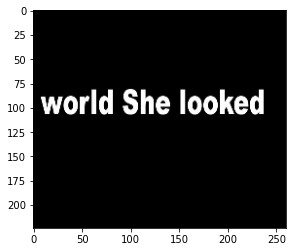

In [63]:
idx = random.randint(0,len(df))
idx,plt.imshow(xFeatures2['encoderInput'][idx]),df.Labels[idx]

In [64]:
# for i in xFeatures:
#     print(xFeatures[i].shape)
# for i in yLabels:
#     print(yLabels[i].shape)

In [65]:
try:
    del xFeatures
    del sentenceSequenceInput
    del sentenceSequenceOutput
except:
    pass

In [66]:
#seqToText(yLabels['decoderOutput'][0],tokenizer)

In [67]:
yLabels['decoderOutput'].shape

(3000, 65, 65)

In [68]:
for i in xFeatures:
    print(xFeatures[i].shape)
for i in yLabels:
    print(yLabels[i].shape)
# xFeatures['encoderInput'][:2]

NameError: name 'xFeatures' is not defined

In [69]:
# aug = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
# )

In [70]:
xFeatures2['encoderInput'].shape

(3000, 224, 260, 3)

In [71]:
# yLabels['decoderOutput'],yLabels['decoderOutput'].shape

In [72]:
# a = aug.flow(xFeatures2['encoderInput'],yLabels['decoderOutput'])
# b = aug.flow(xFeatures2['encoderInput'],xFeatures2['decoderInput'])

In [ ]:
history = model.fit(
          xFeatures2,
          yLabels,
          batch_size=32,
          epochs=20,
          verbose=True,
          workers=-1,
          use_multiprocessing=True
         )
aug.flow(xFeatures,yLabels,batch_size=32)

Epoch 1/20
94/94 [==============================] - 150s 2s/step - loss: 0.9162 - accuracy: 0.7901
Epoch 2/20
94/94 [==============================] - 147s 2s/step - loss: 0.7086 - accuracy: 0.8001
Epoch 3/20
94/94 [==============================] - 158s 2s/step - loss: 0.6836 - accuracy: 0.8090
Epoch 4/20
94/94 [==============================] - 148s 2s/step - loss: 0.6492 - accuracy: 0.8178
Epoch 5/20
94/94 [==============================] - 129s 1s/step - loss: 0.6206 - accuracy: 0.8248
Epoch 6/20
94/94 [==============================] - 139s 1s/step - loss: 0.5992 - accuracy: 0.8305
Epoch 7/20
68/94 [====================>.........] - ETA: 37s - loss: 0.5780 - accuracy: 0.8355

In [ ]:
# loadedModel = tf.keras.models.load_model('imageLabel.h5')

In [ ]:
model.fit(
          xFeatures2,
          yLabels,
          batch_size=32,
          epochs=5,
          verbose=True,
          workers=-1,
          use_multiprocessing=True
         )

In [ ]:
# loadedModel.save('imageLabel.h5')

In [ ]:
# model = loadedModel

In [ ]:
def toText(x):
    result = ''
    for i in x:
        if i != 0 and i in tokenizer.index_word:
            result += tokenizer.index_word[i]
    return result

In [ ]:
idx = random.randint(0,len(df))
plt.imshow(xFeatures2['encoderInput'][idx]),toText(xFeatures2['decoderInput'][idx])

In [ ]:
model.save('imageLabel.h5')

In [ ]:
xFeatures2.keys()

In [ ]:
len(LabelText)

In [ ]:
for i in yLabels['decoderOutput'][2]:
    index = np.argmax(i)
    print(tokenizer.index_word[index] if index!= 0 else '',end='')
yLabels['decoderOutput'][0]

In [ ]:
xFeatures2['encoderInput'].shape,xFeatures2['decoderInput'][0]

In [ ]:
idx = random.randint(0,len(xFeatures2['encoderInput']))
image = xFeatures2['encoderInput'][idx]
image = np.expand_dims(image,axis=0)
dinput = tokenizer.texts_to_sequences([[startSeq]])
dinput = pad_sequences(dinput,maxlen=vocabLength,padding='post',dtype='float32')
# print(dinput)
# calcPred = encoderModel.predict(image)
# for i in calcPred:
#     print(np.argmax(i))
#
x = {
    'encoderInput':image,
    'decoderInput':dinput
}
# initialState = encoderModel.predict(calc)
prediction = model.predict(x,verbose=False)
# #
results = ''
for pred in prediction:
    for i in pred: 
        index = np.argmax(i)
        result = tokenizer.index_word[index] if index != 0 else ''
        results += result
print('prediction:',results)
print('image : ')
plt.imshow(image[0]);

In [ ]:
# loss = history.history['loss']
# accuracy = history.history['accuracy']
# valLoss = history.history['val_accuracy']
# valAcc = history.history['val_loss']
# epochs = [i for i in range(1,21)]
# plt.plot(epochs, loss, "-b", label="loss")
# plt.plot(epochs, accuracy, "-r", label="accuracy")
# plt.plot(epochs, valLoss, label="val_loss")
# plt.plot(epochs, valAcc , label="val_accuracy")
# plt.xlabel('epochs')
# plt.ylabel('Loss and Accuracy')
# plt.legend(loc="upper left")
# plt.grid()
# plt.ylim(0.2, 1.2)
# plt.xlim(0, 22.5)
# plt.show()